In [7]:
import os
import numpy as np

from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord 
import astropy.units as u

from sklearn.neighbors import NearestNeighbors
from sklearn import svm, tree
#from IPython.display import Math

D2R = np.pi/180.0

wdir = os.path.expanduser('~') + '/tmp/LQSO/'

In [23]:
import matplotlib as mp
import matplotlib.pyplot as plt
mp.rcParams['figure.figsize'] = (12, 8)

# Allwise (object type 3) query 

In [3]:
# read the Castle xmatch with DR2
url1 = 'http://vospace.esac.esa.int/vospace/sh/d964d4b3687ede95d64c19609abb3136fbe55c0?dl=1'
t = Table.read(url1,format='votable')
nt = len(t)
print ("Total number of LQSO is {}".format(nt))

Total number of LQSO is 495739


In [9]:
d = t.to_pandas()

In [12]:
d.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495739 entries, 0 to 495738
Columns: 99 entries, qso_id to mu_error
dtypes: float32(44), float64(49), object(6)
memory usage: 291.2+ MB


In [10]:
d.to_csv(wdir+"allwiseDR2.csv")

In [87]:
d[~np.isnan(d.radius_percentile_lower)][:1]

qso_id   solution_id                      designation  \
10003  1.900747e+18  1.635721e+18  b'Gaia DR2 1900747298789142656'   

          source_id  random_index  ref_epoch         ra  ra_error       dec  \
10003  1.900747e+18  1.051281e+09     2015.5  338.03089  0.025339  31.51361   

       dec_error     ...        lum_val  lum_percentile_lower  \
10003   0.029283     ...       1.269214              1.096437   

       lum_percentile_upper  \
10003              1.441991   

                                            datalink_url  \
10003  b'http://geadata.esac.esa.int/data-server/data...   

       epoch_photometry_url        mu  mu_error  freq     mu_norm  mu_norm_max  
10003                   NaN  8.671884  0.080518   2.0  107.701403   107.701403  

[1 rows x 102 columns]

# Castles query

In [89]:
# read the Castle xmatch with DR2
url2 = 'http://vospace.esac.esa.int/vospace/sh/9da5bd4b841f4032ee3f94e2f357067a554434?dl=1'
t2 = Table.read(url2,format='votable')
nt = len(t2)
print ("Total number of LQSO is {}".format(nt))

Total number of LQSO is 87


In [90]:
d2 =  t2.to_pandas()

# Analysis of the significance of the proper motion in Castles data set

one neglect the contamination in AllWise data set

In [91]:
from astropy.coordinates import Angle
def wrap180(x):
    """
    wrap longitudes defined on [0 360] degrees to radian defined on [-pi pi]
    why should I use the minus to get the LMC where I want?
    """
    return -Angle(x,unit=u.deg).wrap_at(180*u.deg).rad

def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error

In [93]:
setMu(d)
setMu(d2)

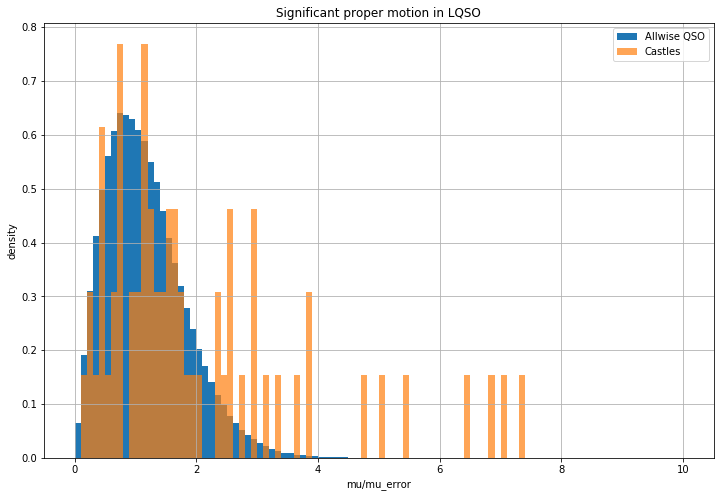

In [99]:
d[d.source_id==d.qso_id].mu_over_error.hist(bins=100,range=(0,10),normed=True,label="Allwise QSO")
d2.mu_over_error.hist(bins=100,range=(0,10),normed=True,label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("density")
plt.xlabel("mu/mu_error")
plt.legend()

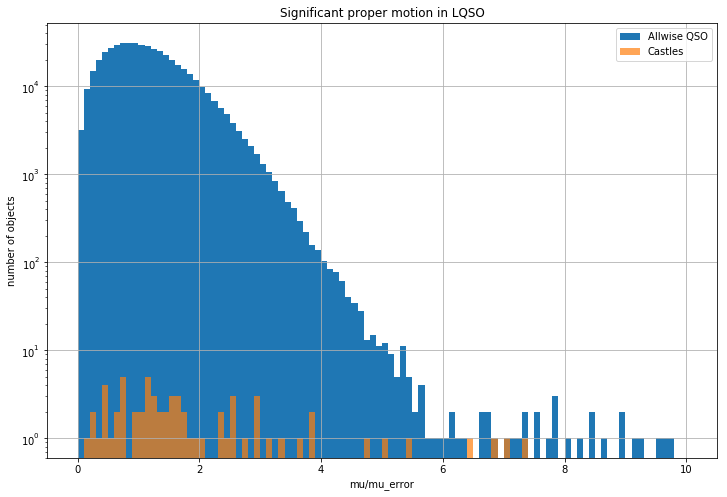

In [108]:
d[d.source_id==d.qso_id].mu_over_error.hist(bins=100,range=(0,10),label="Allwise QSO")
d2.mu_over_error.hist(bins=100,range=(0,10),label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("number of objects")
plt.yscale('log')
plt.xlabel("mu/mu_error")
plt.legend()

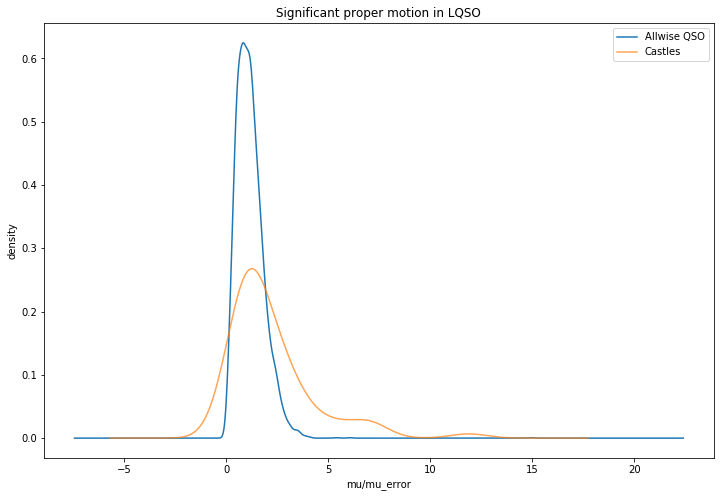

In [100]:
d[d.source_id==d.qso_id].mu_over_error.sample(frac=0.01).plot.kde(label="Allwise QSO")
d2.mu_over_error.plot.kde(label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("density")
plt.xlabel("mu/mu_error")
plt.legend()

In [172]:
from sklearn.neighbors import KernelDensity
def density1d(d,X_plot,colname='mu_over_error',bandwidth=0.5):
    X_fit = d[colname].dropna().values[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_fit)
    log_dens = kde.score_samples(X_plot[:, np.newaxis])
    return np.exp(log_dens)

Text(0.5,1,'Gaussian kde with 0.5 bandwidth')

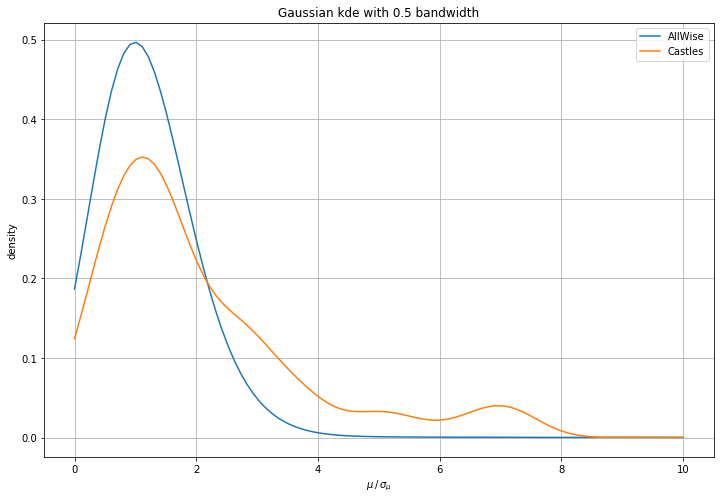

In [174]:
X = np.linspace(0, 10, 100)
plt.plot(X,density1d(d.sample(frac=0.1),X),label="AllWise")
plt.plot(X,density1d(d2,X),label="Castles")
plt.grid()
plt.ylabel("density")
plt.xlabel("$\mu \, / \, \sigma_\mu$")
plt.legend()
plt.title("Gaussian kde with 0.5 bandwidth")

# Analysis of AllWise query

In [16]:
d['freq'] = d.groupby(d.qso_id).source_id.transform('count')
setMu(d)

In [17]:
d['mu_norm_max'] = d.groupby(d.qso_id).mu_norm.transform('max')

In [18]:
g = d.groupby(d.freq)['source_id','qso_id'].count()

In [19]:
g['n_candidate']=g.qso_id/g.index

In [20]:
d.groupby(d.freq).mu_norm.max()

freq
1.0     17.650899
2.0    415.761879
3.0    111.620472
4.0     24.466072
5.0     14.908946
7.0      3.754852
Name: mu_norm, dtype: float64

In [21]:
d.dropna()

Empty DataFrame
Columns: [qso_id, solution_id, designation, source_id, random_index, ref_epoch, ra, ra_error, dec, dec_error, parallax, parallax_error, parallax_over_error, pmra, pmra_error, pmdec, pmdec_error, ra_dec_corr, ra_parallax_corr, ra_pmra_corr, ra_pmdec_corr, dec_parallax_corr, dec_pmra_corr, dec_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr, pmra_pmdec_corr, astrometric_n_obs_al, astrometric_n_obs_ac, astrometric_n_good_obs_al, astrometric_n_bad_obs_al, astrometric_gof_al, astrometric_chi2_al, astrometric_excess_noise, astrometric_excess_noise_sig, astrometric_params_solved, astrometric_primary_flag, astrometric_weight_al, astrometric_pseudo_colour, astrometric_pseudo_colour_error, mean_varpi_factor_al, astrometric_matched_observations, visibility_periods_used, astrometric_sigma5d_max, frame_rotator_object_type, matched_observations, duplicated_source, phot_g_n_obs, phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_flux_over_error, phot_g_mean_mag, phot_bp_n_obs, phot_bp_mean_flux, phot_bp_mean_flux_error, phot_bp_mean_flux_over_error, phot_bp_mean_mag, phot_rp_n_obs, phot_rp_mean_flux, phot_rp_mean_flux_error, phot_rp_mean_flux_over_error, phot_rp_mean_mag, phot_bp_rp_excess_factor, phot_proc_mode, bp_rp, bp_g, g_rp, radial_velocity, radial_velocity_error, rv_nb_transits, rv_template_teff, rv_template_logg, rv_template_fe_h, phot_variable_flag, l, b, ecl_lon, ecl_lat, priam_flags, teff_val, teff_percentile_lower, teff_percentile_upper, a_g_val, a_g_percentile_lower, a_g_percentile_upper, e_bp_min_rp_val, e_bp_min_rp_percentile_lower, e_bp_min_rp_percentile_upper, flame_flags, radius_val, radius_percentile_lower, radius_percentile_upper, lum_val, lum_percentile_lower, lum_percentile_upper, datalink_url, epoch_photometry_url, mu, mu_error, freq, ...]
Index: []

[0 rows x 102 columns]

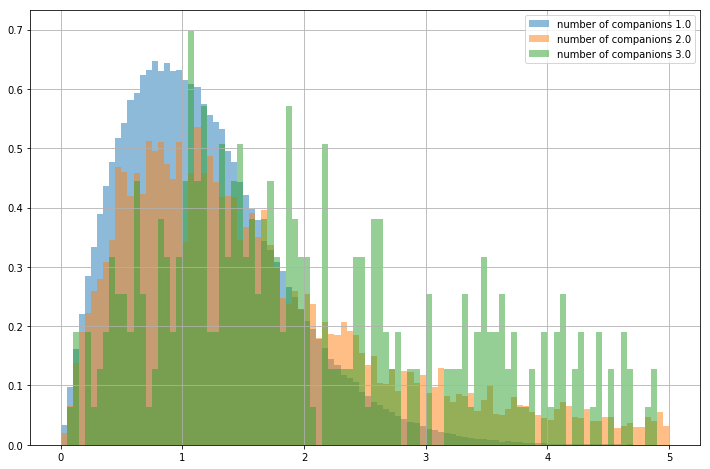

In [24]:
s=d[d.freq<4][['mu','mu_norm','freq']]
for k0,g0 in s.groupby('freq'):
    g0.mu_norm.hist(bins=100,range=(0,5),normed=True,label="number of companions %s"%str(k0),alpha=0.5)
plt.legend()

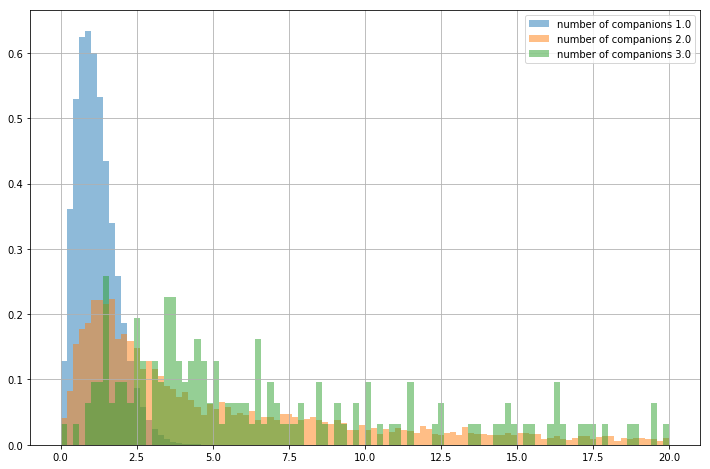

In [25]:
s=d[d.freq<4][['mu','mu_norm','mu_norm_max','freq']]
for k0,g0 in s.groupby('freq'):
    g0.mu_norm_max.hist(bins=100,range=(0,20),normed=True,label="number of companions %s"%str(k0),alpha=0.5)
plt.legend()

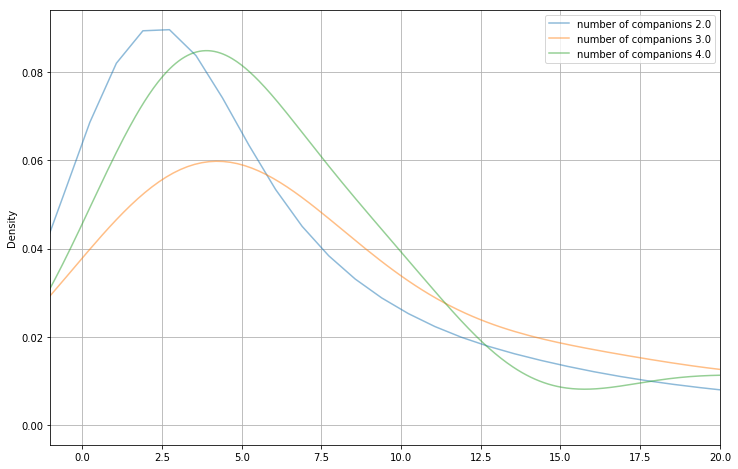

In [26]:
s=d[(d.freq<5) & (d.freq>1)][['mu','mu_norm','mu_norm_max','freq']]
for k0,g0 in s.groupby('freq'):
    g0.mu_norm_max.plot.kde(label="number of companions %s"%str(k0),alpha=0.5)
plt.legend()
plt.xlim(-1,20)
plt.grid()

In [27]:
(s.mu_norm-s.mu_norm_max).max()

0.0

Text(0.5,1,'Allwise QSO with 1 companion')

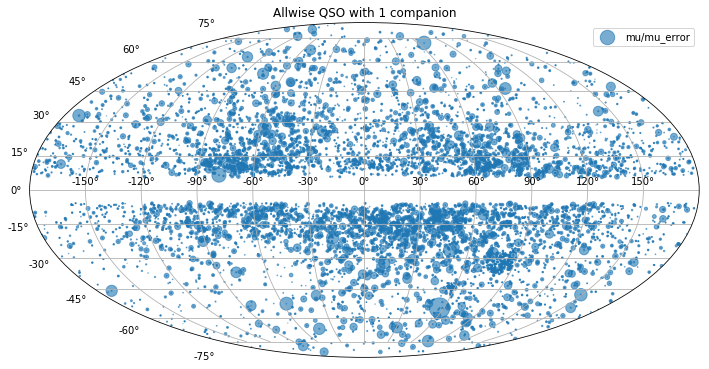

In [28]:
s = d[(d.freq==2)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,s=s.mu_norm,label='mu/mu_error',alpha=0.6)
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 1 companion')

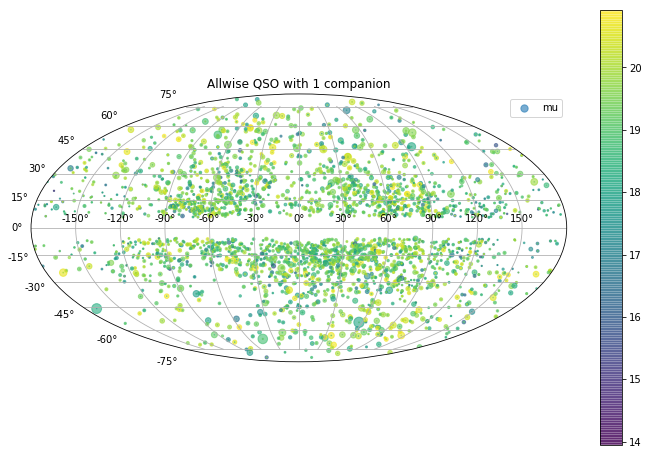

In [29]:
s = d[(d.freq==2) & (d.mu_norm_max>5)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.phot_g_mean_mag,s=s.mu,label='mu',alpha=0.6)
plt.colorbar()
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 1 companion')

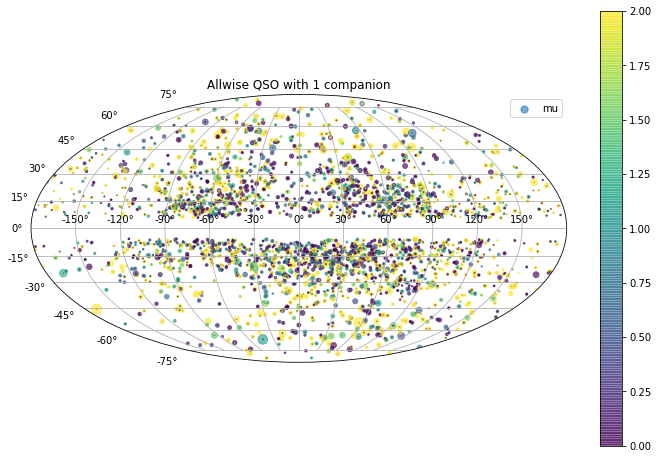

In [32]:
s = d[(d.freq==2) & (d.mu_norm_max>5)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.parallax/s.parallax_error,s=s.mu,label='mu',alpha=0.6,vmin=0,vmax=2)
plt.colorbar()
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 1 companion')

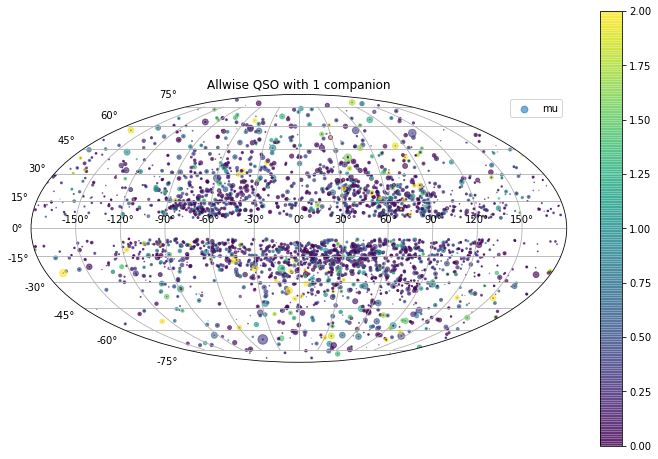

In [36]:
s = d[(d.freq==2) & (d.mu_norm_max>5) & (d.parallax_over_error<3)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.parallax,s=s.mu,label='mu',alpha=0.6,vmin=0,vmax=2)
plt.colorbar()
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

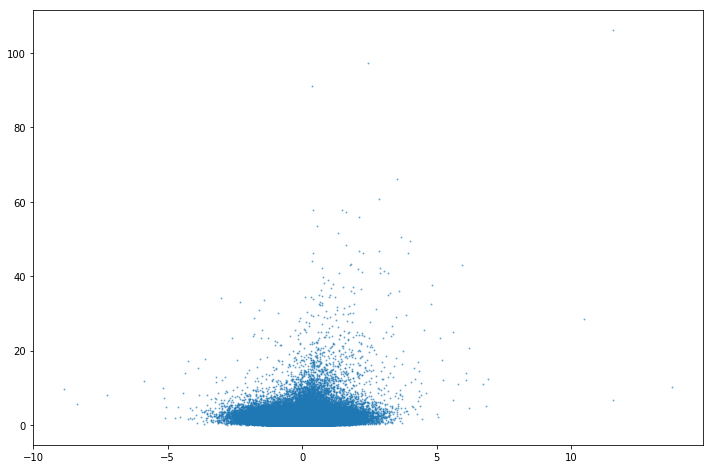

In [45]:
plt.scatter(d.parallax,d.mu,s=1,alpha=0.5)

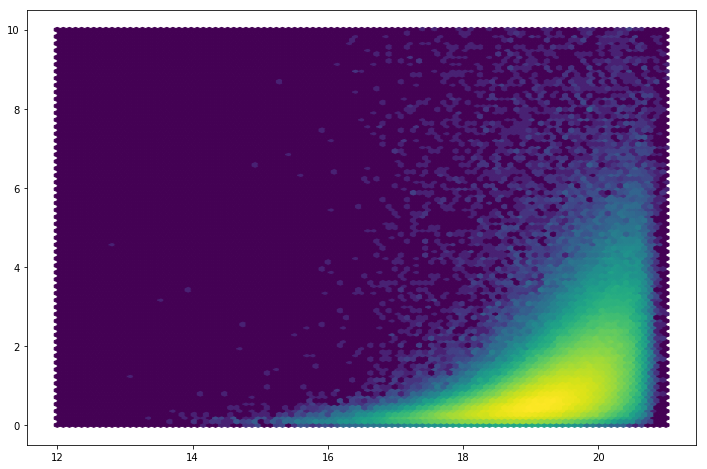

In [76]:
plt.hexbin(d.phot_g_mean_mag,d.mu,extent=(12,21,0,10),bins='log')

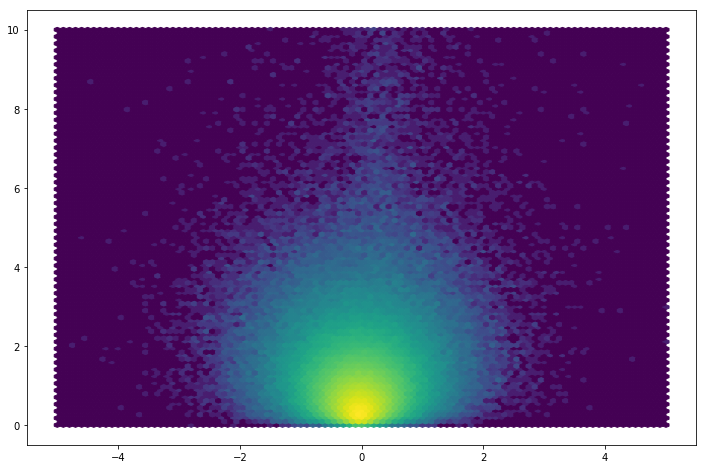

In [62]:
plt.hexbin(d.parallax,d.mu,extent=(-5,5,0,10),bins='log')

Text(0.5,1,'Allwise QSO with 1 companion')

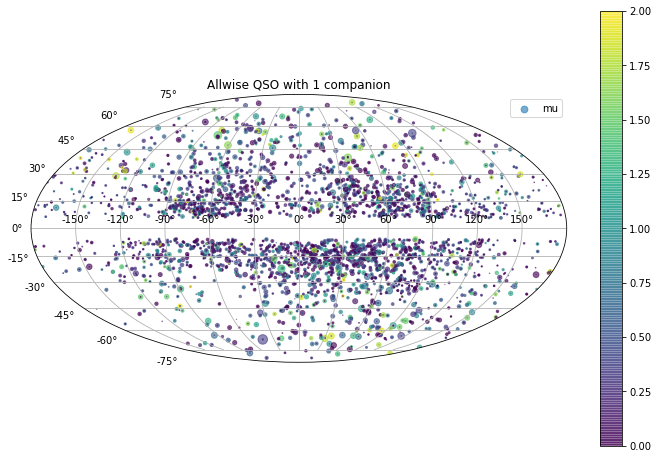

In [38]:
s = d[(d.freq==2) & (d.mu_norm_max>5) & (d.parallax<2)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.parallax,s=s.mu,label='mu',alpha=0.6,vmin=0,vmax=2)
plt.colorbar()
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 2 companions')

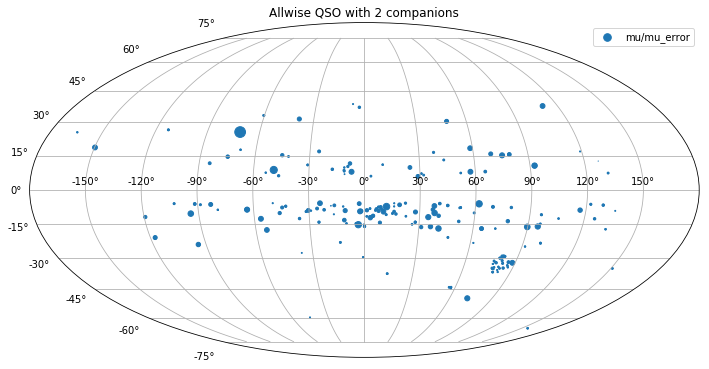

In [68]:
s = d[d.freq==3]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,s=s.mu_norm,label='mu/mu_error')
plt.grid()
plt.legend()
plt.title('Allwise QSO with 2 companions')

Text(0.5,1,'Allwise QSO more than 2 companions')

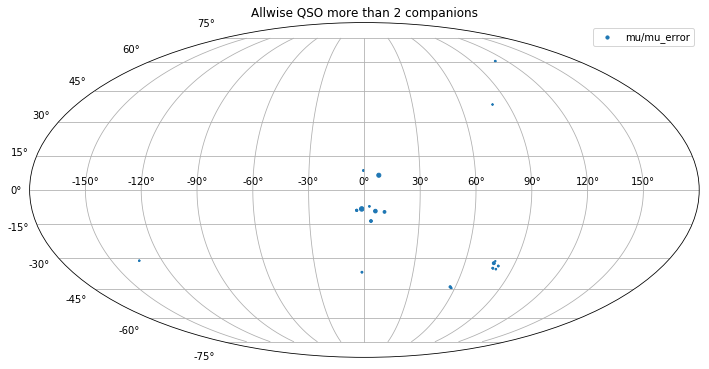

In [182]:
s = d[d.freq>3]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,s=s.mu_norm,label='mu/mu_error')
plt.grid()
plt.legend()
plt.title('Allwise QSO more than 2 companions')

In [ ]:
d[d.freq>3)]

In [14]:
coord = SkyCoord(d.ra,d.dec,unit='deg')

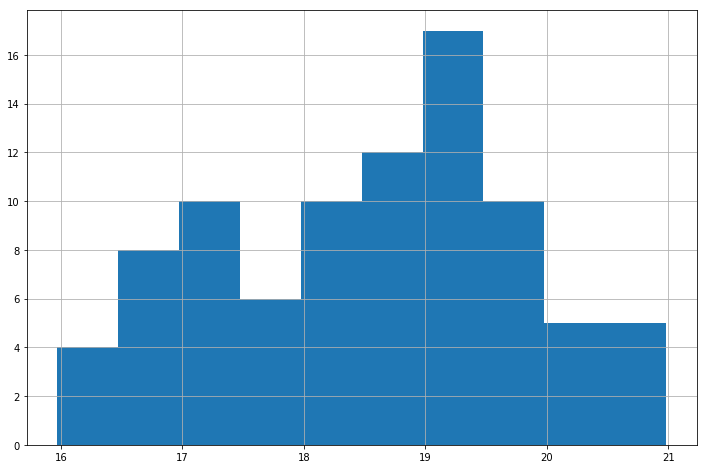

In [21]:
d.phot_g_mean_mag.hist()

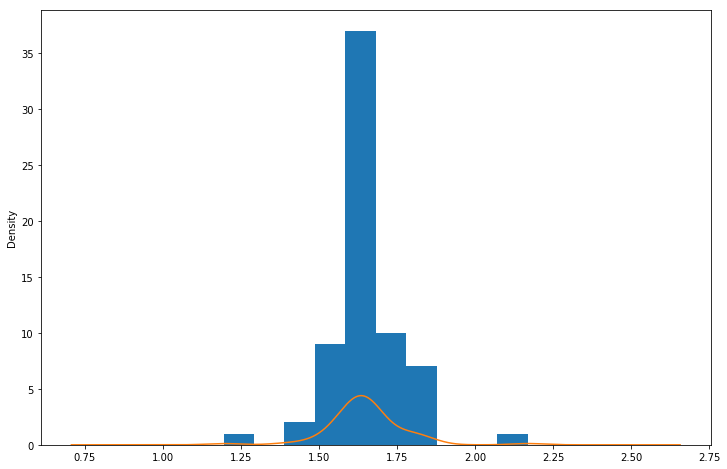

In [33]:
d.astrometric_pseudo_colour.hist()
d.astrometric_pseudo_colour.plot.kde()

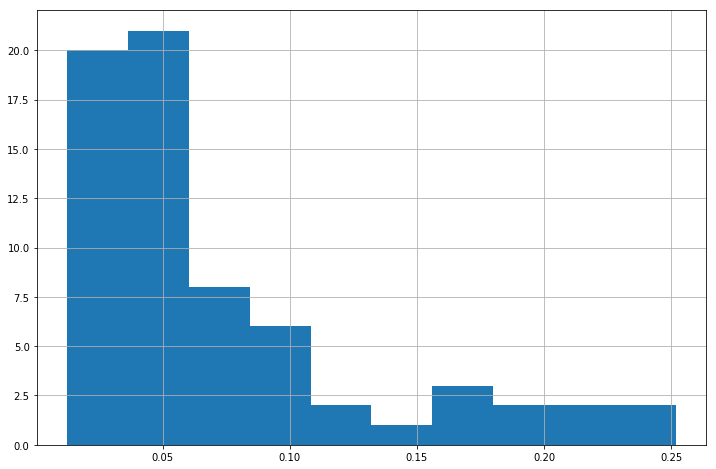

In [39]:
d.astrometric_pseudo_colour_error.hist()

In [36]:
d['test']=d.astrometric_pseudo_colour/d.astrometric_pseudo_colour_error

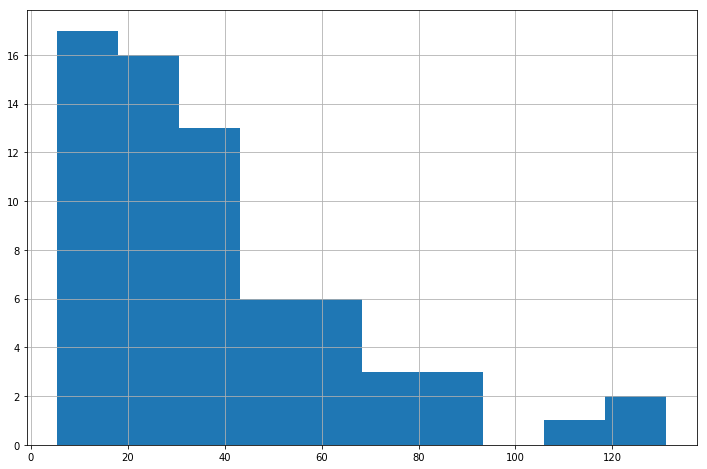

In [38]:
d.test.hist()

In [65]:
def getLQSO(d,center,r=10):
    s = d.copy()
    scale = u.arcsecond.to(u.deg)
    s['x'] = (d.ra-center.ra.deg)/scale
    s['y'] = (d.dec-center.dec.deg)/scale
    return s[np.power(s.x,2)+np.power(s.y,2)<r*r].copy()

def plotGaiaLense(dd,center,r=(-5,5),pm=True):
    d = getLQSO(dd,center)
    scale = u.arcsecond.to(u.deg)
    x = (d.ra-center.ra.deg)/scale
    y = (d.dec-center.dec.deg)/scale
    plt.errorbar(x,y,xerr=d.ra_error, yerr=d.dec_error,fmt='.')
    plt.scatter(x,y,s=100*np.exp(20-d.phot_g_mean_mag),c=d.astrometric_pseudo_colour)
    plt.colorbar()
    if pm : 
        vx = d.pmra
        vy = d.pmdec
        plt.quiver(x,y, vx, vy, angles='xy', scale_units='xy', scale=1)
        plt.errorbar(x+vx,y+vy,xerr=d.pmra_error, yerr=d.pmdec_error,fmt='o')
    plt.grid()
    plt.xlabel("gaia.ra - center.ra [\"]")
    plt.ylabel("gaia.dec - center.dec [\"]")
    plt.title(center)
    plt.xlim(r)
    plt.ylim(r)

In [66]:
getLQSO(d,HE0435)

qso_id   solution_id                      designation  \
163307  3.178021e+18  1.635721e+18  b'Gaia DR2 3178020716638059136'   
163308  3.178021e+18  1.635721e+18  b'Gaia DR2 3178020716638059392'   
163309  3.178021e+18  1.635721e+18  b'Gaia DR2 3178020716640423680'   

           source_id  random_index  ref_epoch         ra  ra_error        dec  \
163307  3.178021e+18   869951248.0     2015.5  69.561604  0.180165 -12.287482   
163308  3.178021e+18   623977900.0     2015.5  69.562038  0.281801 -12.287763   
163309  3.178021e+18   231638665.0     2015.5  69.561885  0.153379 -12.287161   

        dec_error    ...     lum_percentile_upper  \
163307   0.129359    ...                      NaN   
163308   0.229808    ...                      NaN   
163309   0.124867    ...                      NaN   

                                             datalink_url  \
163307  b'http://geadata.esac.esa.int/data-server/data...   
163308  b'http://geadata.esac.esa.int/data-server/data...   
163309  b'http://geadata.esac.esa.int/data-server/data...   

        epoch_photometry_url        mu  mu_error  freq   mu_norm  mu_norm_max  \
163307                   NaN  1.011685  0.392103   3.0  2.580153     2.770591   
163308                   NaN  1.863007  0.672422   3.0  2.770591     2.770591   
163309                   NaN  0.376718  0.341745   3.0  1.102336     2.770591   

               x         y  
163307 -1.355335 -0.330008  
163308  0.208083 -1.341481  
163309 -0.342424  0.825989  

[3 rows x 104 columns]

HE0435 is in ALLwise but an image is missing...

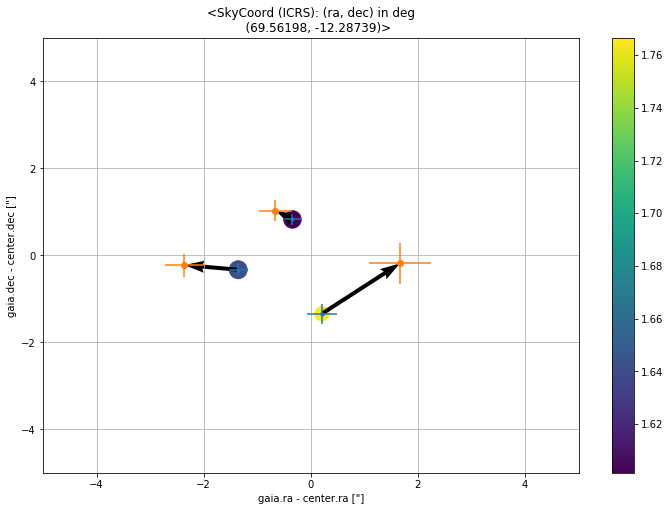

In [71]:
plotGaiaLense(d,HE0435)

In [69]:
centers = d.groupby(d.qso_id)['ra','dec'].mean()